In [71]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedGroupKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset, random_split
import seaborn as sns
from scipy.stats import ttest_rel
from matplotlib.patches import Patch
import seaborn as sns
from sklearn.model_selection import KFold,StratifiedKFold, GroupKFold
from scipy.stats import shapiro
from scipy import stats

In [31]:
#random seed

df = pd.read_csv('HR_data.csv')
#Drop first column
df = df.drop(df.columns[0], axis=1)
#I will binarize the target variable 1 if frustated > 2, 0 otherwise
df['Frustrated'] = df['Frustrated'].apply(lambda x: 1 if x > 2 else 0)


#Making the string attributes nummerical
df = pd.get_dummies(data=df, columns = ['Round', 'Phase','Cohort'])




Index(['HR_Mean', 'HR_Median', 'HR_std', 'HR_Min', 'HR_Max', 'HR_AUC',
       'Individual', 'Puzzler', 'Frustrated', 'Round_round_1', 'Round_round_2',
       'Round_round_3', 'Round_round_4', 'Phase_phase1', 'Phase_phase2',
       'Phase_phase3', 'Cohort_D1_1', 'Cohort_D1_2'],
      dtype='object')

In [32]:
X = df.drop(['Frustrated','Individual'], axis=1)

y = df['Frustrated'].to_numpy()

groups = df['Individual'].to_numpy()
groups

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  9,  9,  9,  9,  9,  9,
        9,  9,  9,  9,  9,  9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12,
       12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 13, 13, 13,
       13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14])

In [63]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

sgkf = StratifiedGroupKFold(n_splits=5)




In [64]:
class FrustrationClassifier(nn.Module):
    def __init__(self, input_size):
        super(FrustrationClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, 1)  # Output layer for binary classification
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc3(x))  # Sigmoid activation for binary classification
        return x

In [65]:
def train_and_evaluate_nn(X_train, y_train, X_test, y_test, num_features):
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

    model = FrustrationClassifier(input_size=num_features)
    criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    num_epochs = 20
    for epoch in range(num_epochs):
        model.train()
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

    model.eval()
    with torch.no_grad():
        outputs = model(X_test_tensor)
        predicted = (outputs > 0.5).float()
        nn_accuracy = accuracy_score(y_test_tensor, predicted)
    return nn_accuracy




# Train and evaluate using StratifiedGroupKFold
random_state = 42
rf_accuracies = []
nn_accuracies = []

for train_index, test_index in sgkf.split(X, y, groups):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Train the RandomForestClassifier
    rf_model = RandomForestClassifier(random_state=random_state, n_estimators=100)
    rf_model.fit(X_train, y_train)
    rf_predictions = rf_model.predict(X_test)
    rf_accuracy = accuracy_score(y_test, rf_predictions)
    rf_accuracies.append(rf_accuracy)
    print(f'RandomForestClassifier Accuracy: {rf_accuracy:.4f}')

    # Train and evaluate the neural network
    num_features = X_train.shape[1]
    nn_accuracy = train_and_evaluate_nn(X_train, y_train, X_test, y_test, num_features)
    nn_accuracies.append(nn_accuracy)
    print(f'Neural Network Accuracy: {nn_accuracy:.4f}')

# Print the average accuracies
print(f'Average RandomForestClassifier Accuracy: {np.mean(rf_accuracies):.4f}')
print(f'Average Neural Network Accuracy: {np.mean(nn_accuracies):.4f}')


RandomForestClassifier Accuracy: 0.5278
Neural Network Accuracy: 0.6111
RandomForestClassifier Accuracy: 0.5000
Neural Network Accuracy: 0.7500
RandomForestClassifier Accuracy: 0.7778
Neural Network Accuracy: 0.7500
RandomForestClassifier Accuracy: 0.5833
Neural Network Accuracy: 0.7083
RandomForestClassifier Accuracy: 0.8056
Neural Network Accuracy: 0.7222
Average RandomForestClassifier Accuracy: 0.6389
Average Neural Network Accuracy: 0.7083


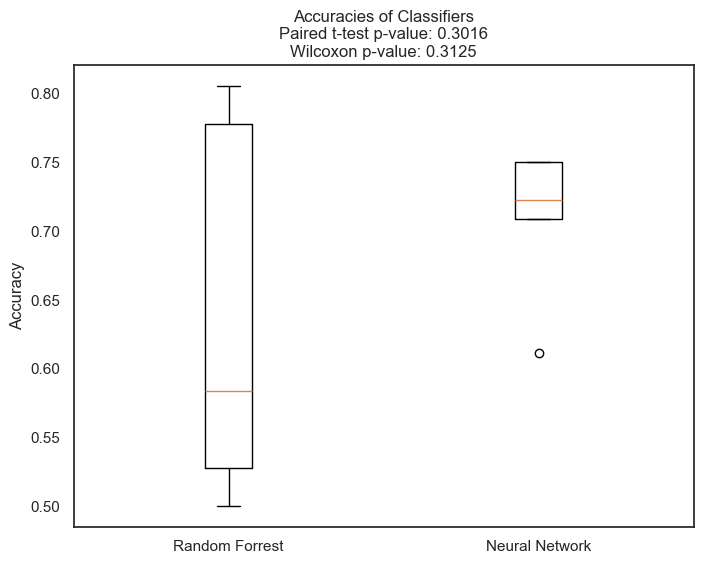

In [72]:
#Comparing the two models

t_statistic, p_value_ttest = stats.ttest_rel(rf_accuracies, nn_accuracies)
wilcoxon_statistic, p_value_wilcoxon = stats.wilcoxon(rf_accuracies, nn_accuracies)

#Check if normaldistribution with shaprio test
plt.figure(figsize=(8, 6))

# Combined boxplot for both classifiers
plt.boxplot([rf_accuracies, nn_accuracies], labels=['Random Forrest', 'Neural Network'])
plt.title(f'Accuracies of Classifiers\nPaired t-test p-value: {p_value_ttest:.4f}\nWilcoxon p-value: {p_value_wilcoxon:.4f}')
plt.ylabel('Accuracy')

plt.show()

In [73]:
rng=np.random.RandomState(87)  # deterministic random data
cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm
n_splits = 14
diff = []

for i in range(len(rf_accuracies)):
    diff.append(rf_accuracies[i] - nn_accuracies[i])

test, pval = shapiro(diff)
print('Statistics=%.3f, p=%.3f' % (test, pval))

(0.5278 + 0.5000 + 0.7778 + 0.5833 + 0.8056) /5

Statistics=0.972, p=0.891


0.6389

In [ ]:

# Load the data
df = pd.read_csv('HR_data.csv')
df = df.drop(df.columns[0], axis=1)
df = pd.get_dummies(data=df, columns = ['Round', 'Phase','Cohort'])

# Define features and target
X = df.drop(columns=['Frustrated', 'Individual'])

y = df['Frustrated']
groups = df['Individual']

# Binarize the target variable using the median
median_value = y.median()
y_binarized = (y > median_value).astype(int)
y = y_binarized

# Initialize StratifiedGroupKFold
sgkf = StratifiedGroupKFold(n_splits=5)

# Visualize dataset groups and classes



In [ ]:
def plot_cv_indices(cv, X, y, group, ax, n_splits, lw=10):
    """Create a sample plot for indices of a cross-validation object."""

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y, groups=group)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(
            range(len(indices)),
            [ii + 0.5] * len(indices),
            c=indices,
            marker="_",
            lw=lw,
            cmap=cmap_cv,
            vmin=-0.2,
            vmax=1.2,
        )

    # Plot the data classes and groups at the end
    ax.scatter(
        range(len(X)), [ii + 1.5] * len(X), c=y, marker="_", lw=lw, cmap=cmap_data
    )

    ax.scatter(
        range(len(X)), [ii + 2.5] * len(X), c=group, marker="_", lw=lw, cmap=cmap_data
    )

    # Formatting
    yticklabels = list(range(n_splits)) + ["class", "group"]
    ax.set(
        yticks=np.arange(n_splits + 2) + 0.5,
        yticklabels=yticklabels,
        xlabel="Sample index",
        ylabel="CV iteration",
        ylim=[n_splits + 2.2, -0.2],
        xlim=[0, 100],
    )
    ax.set_title("{}".format(type(cv).__name__), fontsize=15)
    return ax

<Axes: title={'center': 'KFold'}, xlabel='Sample index', ylabel='CV iteration'>

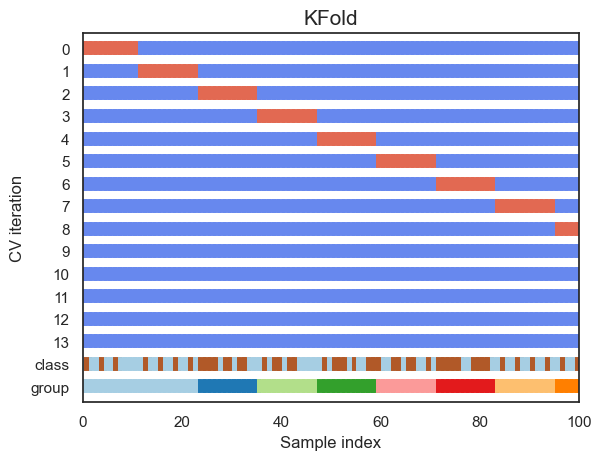

In [ ]:
fig, ax = plt.subplots()
cv = KFold(n_splits)
plot_cv_indices(cv, X, y, groups, ax, n_splits)

(0.0, 170.0)

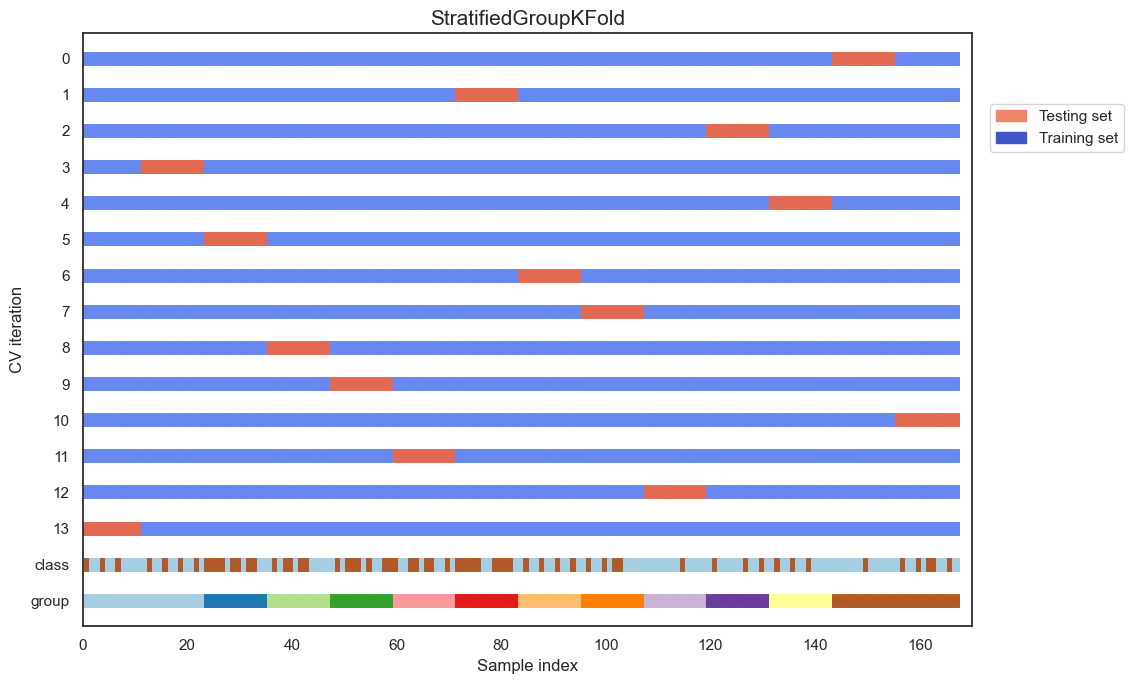

In [ ]:
cv = StratifiedGroupKFold


fig, ax = plt.subplots(figsize=(14, 7))
plot_cv_indices(cv(n_splits), X, y, groups, ax, n_splits)
ax.legend(
    [Patch(color=cmap_cv(0.8)), Patch(color=cmap_cv(0.02))],
    ["Testing set", "Training set"],
    loc=(1.02, 0.8),
)
# Make the legend fit
plt.tight_layout()
fig.subplots_adjust(right=0.7)
plt.xlim(0,170)


In [ ]:
start = 400000
gain = 1.1

for i in range(10):
    start = start * gain
    print(start)

440000.00000000006
484000.0000000001
532400.0000000001
585640.0000000002
644204.0000000003
708624.4000000005
779486.8400000005
857435.5240000007
943179.0764000008
1037496.984040001


Neural Network